In [1]:
import numpy as np
import pandas as pd
from numba import jit, njit, vectorize
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('bmh')

In [3]:
def original_function(input_lst):
    output_lst = list()
    for item in input_lst:
        if item % 2 == 0:
            output_lst.append(2)
        else:
            output_lst.append('1')  # this mixing of types is a problem for numba
    return output_lst

test_lst = list(range(10_000))

In [3]:
%timeit original_function(test_lst)

1.19 ms ± 28.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [4]:
jitted_original = jit()(original_function) 

This should raise a warning because output_lst is not containing just int64

In [5]:
%timeit jitted_original(test_lst)

<ipython-input-2-427c6da15cfc>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "original_function" failed type inference due to: Invalid use of BoundFunction(list.append for list(int64)) with parameters (Literal[str](1))
 * parameterized
[1] During: resolving callee type: BoundFunction(list.append for list(int64))
[2] During: typing of call at <ipython-input-2-427c6da15cfc> (7)


File "<ipython-input-2-427c6da15cfc>", line 7:
def original_function(input_lst):
    <source elided>
        else:
            output_lst.append('1')  # this mixing of types is a problem for numba
            ^

  def original_function(input_lst):
<ipython-input-2-427c6da15cfc>:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "original_function" failed type inference due to: cannot determine Numba type of <class 'numba.dispatcher.LiftedLoop'>

File "<ipython-input-2-427c6da15cfc>", line 3:
def origin

2.21 ms ± 149 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


/Users/allan/miniconda3/envs/py37/lib/python3.7/site-packages/numba/compiler.py:742: NumbaWarning: Function "original_function" was compiled in object mode without forceobj=True.

File "<ipython-input-2-427c6da15cfc>", line 3:
def original_function(input_lst):
    <source elided>
    output_lst = list()
    for item in input_lst:
    ^

  self.func_ir.loc))
/Users/allan/miniconda3/envs/py37/lib/python3.7/site-packages/numba/compiler.py:751: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "<ipython-input-2-427c6da15cfc>", line 3:
def original_function(input_lst):
    <source elided>
    output_lst = list()
    for item in input_lst:
    ^

  warnings.warn(errors.NumbaDeprecationWarning(msg, self.func_ir.loc))


Using the `njit`-function (or `jit(no_python=True)` should raise an error

In [6]:
jitted_original = jit(nopython=True)(original_function)

In [7]:
%timeit jitted_original(test_lst)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Invalid use of BoundFunction(list.append for list(int64)) with parameters (Literal[str](1))
 * parameterized
[1] During: resolving callee type: BoundFunction(list.append for list(int64))
[2] During: typing of call at <ipython-input-2-427c6da15cfc> (7)


File "<ipython-input-2-427c6da15cfc>", line 7:
def original_function(input_lst):
    <source elided>
        else:
            output_lst.append('1')  # this mixing of types is a problem for numba
            ^

This is not usually a problem with Numba itself but instead often caused by
the use of unsupported features or an issue in resolving types.

To see Python/NumPy features supported by the latest release of Numba visit:
http://numba.pydata.org/numba-doc/latest/reference/pysupported.html
and
http://numba.pydata.org/numba-doc/latest/reference/numpysupported.html

For more information about typing errors and how to debug them visit:
http://numba.pydata.org/numba-doc/latest/user/troubleshoot.html#my-code-doesn-t-compile

If you think your code should work with Numba, please report the error message
and traceback, along with a minimal reproducer at:
https://github.com/numba/numba/issues/new


In [8]:
def just_int_function(input_lst):
    output_lst = list()
    for item in input_lst:
        if item % 2 == 0:
            output_lst.append(2)
        else:
            output_lst.append(1)  # not using an int
    return output_lst

test_lst = list(range(10_000))

In [9]:
%timeit just_int_function(test_lst)

1 ms ± 12.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [10]:
jitted_just_int_function = njit()(just_int_function)

In [11]:
%timeit jitted_just_int_function(test_lst)

/Users/allan/miniconda3/envs/py37/lib/python3.7/site-packages/numba/ir_utils.py:1959: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'input_lst' of function 'just_int_function'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-8-4d43ca9232c4>", line 1:
def just_int_function(input_lst):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


20.4 ms ± 1.49 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
test_arr = np.arange(10_000)

In [14]:
%timeit just_int_function(test_arr)

6.19 ms ± 92.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
jitted_just_int_function = njit()(just_int_function)
_ = jitted_just_int_function(test_arr)
%timeit jitted_just_int_function(test_arr)

250 µs ± 7.13 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [20]:
@vectorize
def scalar_computation_1(num):
    if num % 2 == 0:
        return 2
    else:
        return 1
    

@vectorize
def scalar_computation_2(num):
    if num % 2 == 0:
        return 2
    return 1

In [18]:
%time scalar_computation_1(test_arr)

CPU times: user 83.6 ms, sys: 3.45 ms, total: 87.1 ms
Wall time: 85.6 ms


array([2, 1, 2, ..., 1, 2, 1])

In [21]:
%time scalar_computation_2(test_arr)

CPU times: user 67.9 ms, sys: 2.9 ms, total: 70.8 ms
Wall time: 70 ms


array([2, 1, 2, ..., 1, 2, 1])

In [22]:
scalar_computation_1(234)

2

In [23]:
scalar_computation(12341)

1

In [38]:
@njit
def fixed_function_0(arr):
    n = arr.shape[0]
    to_return = np.zeros(n)
    for i in range(n):
        if arr[i] & 2 == 0:
            to_return[i] = 2
        else:
            to_return[i] = 1
    return to_return


@njit
def fixed_function_1(arr):
    to_return = np.zeros_like(arr)
    for ii, item in enumerate(arr):
        if item & 2 == 0:
            to_return[ii] = 2
        else:
            to_return[ii] = 1
    return to_return


@njit
def fixed_function_2(arr):
    to_return = np.zeros_like(arr)
    for ii, item in enumerate(arr):
        to_return[ii] = 2 - (item % 2 == 0)
    return to_return


@njit
def fixed_function_3(arr):
    to_return = np.zeros_like(arr)
    for ii, item in enumerate(arr):
        to_return[ii] = item % 2 + 1
    return to_return


@njit
def fixed_function_4(arr):
    n = arr.shape[0]
    to_return = np.zeros(n)
    for i in range(n):
        to_return[i] = arr[i] % 2 + 1
    return to_return


@njit
def fixed_function_5(arr):
    n = arr.shape[0]
    to_return = np.zeros(n)
    for i in range(n):
        to_return[i] = arr[i] % 2 + 1
    return to_return


fixed_function_0(test_arr);
fixed_function_1(test_arr);
fixed_function_2(test_arr);
fixed_function_3(test_arr);
fixed_function_4(test_arr);
fixed_function_5(test_arr);

In [39]:
%timeit fixed_function_0(test_arr)
%timeit fixed_function_1(test_arr)
%timeit fixed_function_2(test_arr)
%timeit fixed_function_3(test_arr)
%timeit fixed_function_4(test_arr)
%timeit fixed_function_5(test_arr)

5.28 µs ± 249 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
7.01 µs ± 623 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
9.08 µs ± 799 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
8.61 µs ± 777 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
14.8 µs ± 89.6 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
18.8 µs ± 1.09 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


Doing the crazy springy thing (harmonic-ish oscilator)

In [72]:
def friction_fn(v, vt):
    if v > vt:
        return -3 * v
    return -3 * vt * np.sign(v)


def simulate_spring_mass_funky_damper(x0, t_max=10, dt=0.0001, vt=1.0):
    time_arr = np.arange(0, t_max, dt)
    position_arr = np.zeros_like(time_arr) * np.NaN
    
    v, a, x = 0, 0, x0
    position_arr[0] = x0/x0
    
    for i in range(1, time_arr.shape[0]):
        t = time_arr[i]
        a = friction_fn(v, vt) - 100*x
        v = v + a*dt
        x = x + v * dt
        position_arr[i] = x / x0
        
    return time_arr, position_arr

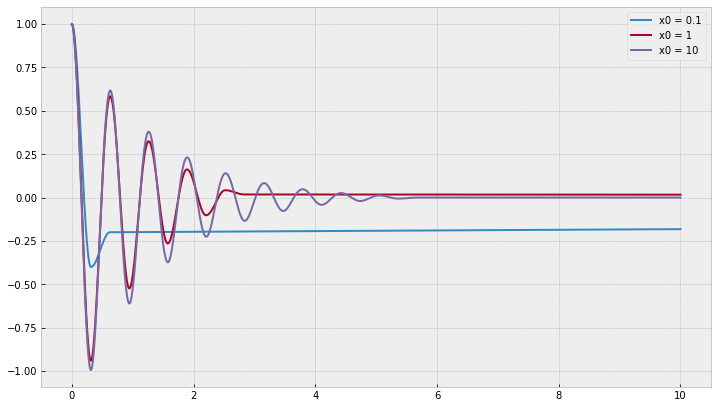

In [73]:
fig, ax = plt.subplots(figsize=[12, 7])
ax.plot(*simulate_spring_mass_funky_damper(0.1), label='x0 = 0.1')
ax.plot(*simulate_spring_mass_funky_damper(1), label='x0 = 1')
ax.plot(*simulate_spring_mass_funky_damper(10), label='x0 = 10')
ax.legend(loc='upper right') 

In [74]:
%timeit simulate_spring_mass_funky_damper(1) 

319 ms ± 9.33 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [4]:
@njit
def jitted_friction_fn(v, vt):
    if v > vt:
        return -3 * v
    return -3 * vt * np.sign(v)

@njit
def jitted_simulate_spring_mass_funky_damper(x0, t_max=10, dt=0.0001, vt=1.0):
    time_arr = np.arange(0, t_max, dt)
    position_arr = np.zeros_like(time_arr) * np.NaN
    
    v, a, x = 0, 0, x0
    position_arr[0] = x0/x0
    
    for i in range(1, time_arr.shape[0]):
        t = time_arr[i]
        a = jitted_friction_fn(v, vt) - 100*x
        v = v + a*dt
        x = x + v * dt
        position_arr[i] = x / x0
        
    return time_arr, position_arr 

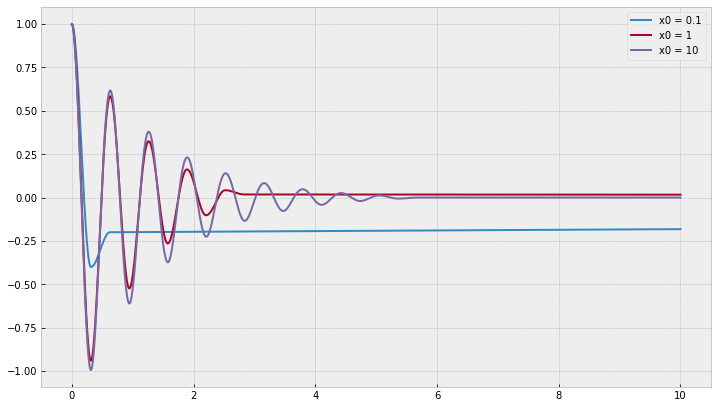

In [76]:
fig, ax = plt.subplots(figsize=[12, 7])
ax.plot(*jitted_simulate_spring_mass_funky_damper(0.1), label='x0 = 0.1')
ax.plot(*jitted_simulate_spring_mass_funky_damper(1), label='x0 = 1')
ax.plot(*jitted_simulate_spring_mass_funky_damper(10), label='x0 = 10')
ax.legend(loc='upper right') 

In [77]:
%timeit jitted_simulate_spring_mass_funky_damper(1) 

1.01 ms ± 41.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [27]:
@njit
def jitted_friction_fn(v, vt):
    if v > vt:
        return -3 * v
    return -3 * vt * np.sign(v)

@njit
def jitted_simulate_spring_mass_funky_damper(x0, t_max=10, dt=0.0001, vt=1.0):
    time_arr = np.arange(0, t_max, dt)
    position_arr = np.zeros_like(time_arr) * np.NaN
    
    v, a, x = 0, 0, x0
    position_arr[0] = x0/x0
    
    for i in range(1, time_arr.shape[0]):
        t = time_arr[i]
        a = jitted_friction_fn(v, vt) - 100*x
        v += a*dt
        x += v * dt
        position_arr[i] = x / x0
        
    return time_arr, position_arr 


jitted_simulate_spring_mass_funky_damper(1);
%timeit jitted_simulate_spring_mass_funky_damper(1) 

997 µs ± 29.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Even though we aren't using any part of the Python engine, the GIL is not released until we explicitly tell it to be:

In [28]:
from concurrent.futures import ThreadPoolExecutor

In [29]:
%%timeit

with ThreadPoolExecutor(8) as pool:
    pool.map(jitted_simulate_spring_mass_funky_damper, np.arange(0.1, 100))

104 ms ± 1.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
@njit(nogil=True)
def jitted_friction_fn(v, vt):
    if v > vt:
        return -3 * v
    return -3 * vt * np.sign(v)

@njit(nogil=True)
def jitted_simulate_spring_mass_funky_damper(x0, t_max=10, dt=0.0001, vt=1.0):
    time_arr = np.arange(0, t_max, dt)
    position_arr = np.zeros_like(time_arr) * np.NaN
    
    v, a, x = 0, 0, x0
    position_arr[0] = x0/x0
    
    for i in range(1, time_arr.shape[0]):
        t = time_arr[i]
        a = jitted_friction_fn(v, vt) - 100*x
        v += a*dt
        x += v * dt
        position_arr[i] = x / x0
        
    return time_arr, position_arr 


In [31]:
%%timeit

with ThreadPoolExecutor(8) as pool:
    pool.map(jitted_simulate_spring_mass_funky_damper, np.arange(0.1, 100))

22.8 ms ± 2.76 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Paralellizing usnig numba `prange` (like openmp) are a bit faster than the `ThreadPoolExecutor`

In [32]:
from numba import prange

In [33]:
@njit(parallel=True)
def run_sims(end=100):
    n_runs = int(end//0.1)
    to_return = np.NaN * np.zeros((n_runs, 2, 100000))
    for i in prange(n_runs): 
        if i == 0:
            continue
        times, positions = (jitted_simulate_spring_mass_funky_damper(i*0.1))
        to_return[i, 0, :] = times
        to_return[i, 1, :] = positions
    return to_return

In [34]:
%time run_sims()

CPU times: user 5.57 s, sys: 3.64 s, total: 9.21 s
Wall time: 2.76 s


array([[[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]],

       [[ 0.00000000e+00,  1.00000000e-04,  2.00000000e-04, ...,
          9.99970000e+00,  9.99980000e+00,  9.99990000e+00],
        [ 1.00000000e+00,  9.99999000e-01,  9.99997300e-01, ...,
         -1.82103434e-01, -1.82103237e-01, -1.82103157e-01]],

       [[ 0.00000000e+00,  1.00000000e-04,  2.00000000e-04, ...,
          9.99970000e+00,  9.99980000e+00,  9.99990000e+00],
        [ 1.00000000e+00,  9.99999000e-01,  9.99997150e-01, ...,
         -8.45045367e-02, -8.45043824e-02, -8.45042937e-02]],

       ...,

       [[ 0.00000000e+00,  1.00000000e-04,  2.00000000e-04, ...,
          9.99970000e+00,  9.99980000e+00,  9.99990000e+00],
        [ 1.00000000e+00,  9.99999000e-01,  9.99997000e-01, ...,
         -2.13019969e-04, -2.13019

In [35]:
@njit(parallel=True)
def run_sims(end=100):
    n_runs = int(end//0.1)
    for i in prange(n_runs): 
        if i == 0:
            continue
        jitted_simulate_spring_mass_funky_damper(i*0.1) 

In [36]:
%timeit run_sims() 

200 ms ± 9.38 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
f"{np.prod((10_000, 2, 100000)) * 64 / (8 * 1e9)} GB used for preallocation of result"

'16.0 GB used for preallocation of result'